# On Analyzing Real World Time Series for Forecasting: Bitcoin Price Dataset (2017-2023)

In [1]:
import os
import sys
import torch

import torch.nn as nn
import torch.optim as optim

# Get the current working directory of the notebook
notebook_dir = os.getcwd()
sys.path.append(os.path.join(notebook_dir, '../tslearn/'))
from ml_models import MLP
from data_loader import build_bitcoin_uts
from ts_models import RandomWalk, ARIMA_model, EvaluationMetric

## Data Pipeline

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Initialize & Predict Random Walk Model on Raw Data
    1. Split Raw Data
7. Difference
8. Get Descriptive Statistics (ie: mean, median, etc)
9. Check Stationarity of Differenced Data
10. Plot Autocorrelation and Partial Autocorrelation of Differenced Data
11. Initialize & Predict Random Walk `RW` Model on Raw Data
    1. Split Differenced Data
12. Initialize Autoregressive `AR(p)` Model
13. Predict Forecasts for Returns Data
14. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
15. Follow-up

### Load Raw Data

In [2]:
reversed_bitcoin_ts = build_bitcoin_uts()

In [3]:
reversed_bitcoin_df = reversed_bitcoin_ts.get_as_df()
reversed_bitcoin_df

,close
Timestamp,
2023-08-01,28902.49
2023-08-01,28902.49
2023-08-01,28902.49
2023-08-01,28908.53
2023-08-01,28907.41
...,...
2017-08-17,4261.48
2017-08-17,4261.48
2017-08-17,4280.56


In [4]:
bitcoin_ts = reversed_bitcoin_ts.data_augment_reverse()
bitcoin_ts

UnivariateTimeSeries(close)

In [5]:
bitcoin_df = bitcoin_ts.get_as_df()
bitcoin_df

,close
Timestamp,
2017-08-17,4261.48
2017-08-17,4261.48
2017-08-17,4280.56
2017-08-17,4261.48
2017-08-17,4261.48
...,...
2023-08-01,28907.41
2023-08-01,28908.53
2023-08-01,28902.49


### Plot Raw Data

- August 2017 to July 2023. The data has been meticulously collected from the Binance API, with price data captured at **one-minute intervals** [About Dataset](https://www.kaggle.com/datasets/jkraak/bitcoin-price-dataset)

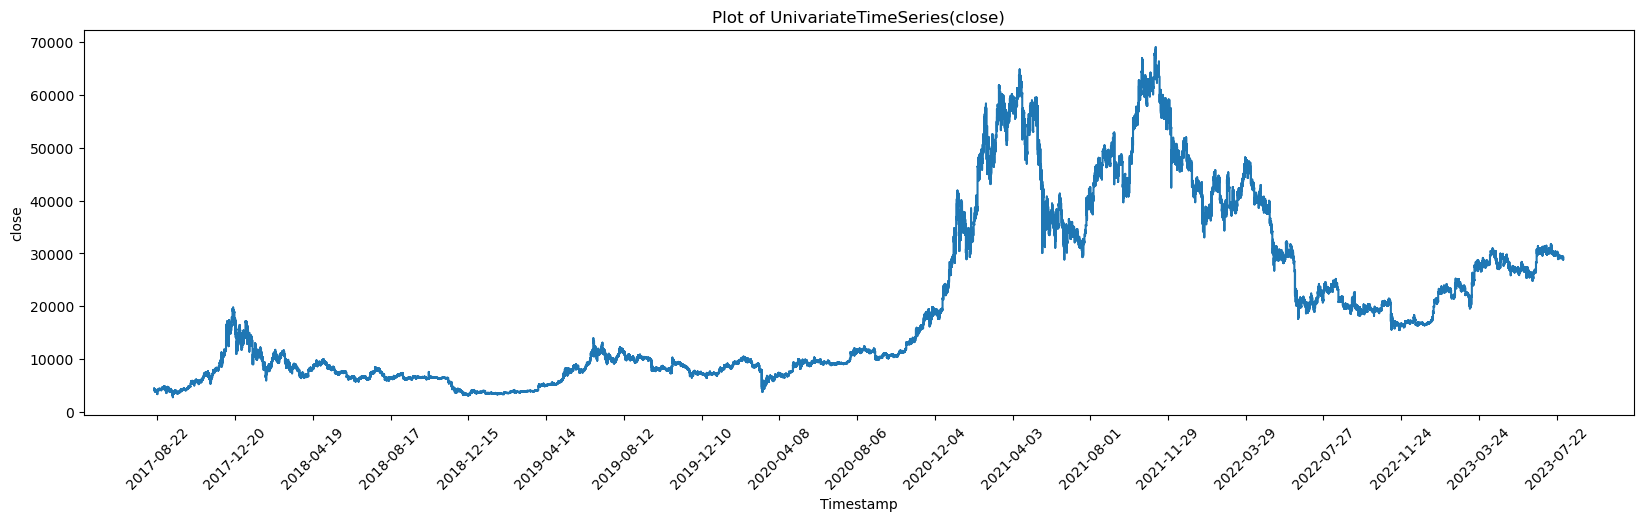

In [6]:
bitcoin_ts.plot(tick_skip=120)

### Get Descriptive Statistics of Raw Data

In [7]:
bitcoin_ts.get_statistics()

,close
count,3.126000e+06
mean,2.008946e+04
std,1.605896e+04
min,2.817000e+03
25%,7.624798e+03
50%,1.170000e+04
75%,2.989957e+04
max,6.900000e+04


In [8]:
bitcoin_ts.range_skewness_kurtosis()

{'Range': close    66183.0
 dtype: float64,
 'Skewness': close    1.029161
 dtype: float64,
 'Kurtosis': close   -0.056707
 dtype: float64}

### Check Stationarity of Raw Data

In [9]:
# both a taking a while
# bitcoin_ts.stationarity_test(bitcoin_df)

# from statsmodels.tsa.stattools import adfuller, bds

# adfuller(bitcoin_df)

- Stationarity test is taking a while. From looking at the graph, we can see that the time series is NOT stationary, so we can difference.

In [10]:
# bitcoin_series = bitcoin_ts.get_series()
# bitcoin_ts.independence_test(bitcoin_series)

- Independence test is taking a while as well. Assume that the data is dependent as there is correlation due to the time series being non-stationary.

### Initialize & Predict (RW) Model of Raw Data
- RW uses the raw data because the current observation depends on the previous, thus dependency is need and dependency is in raw data. Differencing removes this dependence.

In [11]:
bitcoin_series = bitcoin_ts.get_series()
bitcoin_series

array([ 4261.48,  4261.48,  4280.56, ..., 28902.49, 28902.49, 28902.49])

In [12]:
day_forecast = 60 * 24
year_forecast = day_forecast * 365
forecasting_step = year_forecast
N = len(bitcoin_ts.get_series())
train_length = N - forecasting_step
train_length

2600400

In [13]:
train_uts, test_uts = bitcoin_ts.get_slice(1, train_length, both_train_test=True)
train_uts, test_uts

1 2600400


(UnivariateTimeSeries(UnivariateTimeSeries(close)[1:2600400]),
 UnivariateTimeSeries(UnivariateTimeSeries(close)[2600400:3126000]))

In [14]:
train_df = train_uts.get_as_df()
train_df

,UnivariateTimeSeries(close)[1:2600400]
Timestamp,
2017-08-17,4261.48
2017-08-17,4280.56
2017-08-17,4261.48
2017-08-17,4261.48
2017-08-17,4261.48
...,...
2022-08-01,22932.67
2022-08-01,22938.14
2022-08-01,22947.96


In [15]:
test_df = test_uts.get_as_df()
test_df

,UnivariateTimeSeries(close)[2600400:3126000]
Timestamp,
2022-08-01,22941.82
2022-08-01,22914.89
2022-08-01,22936.11
2022-08-01,22886.88
2022-08-01,22873.86
...,...
2023-08-01,28907.41
2023-08-01,28908.53
2023-08-01,28902.49


In [16]:
# rw_model_class = RandomWalk()

# rw_predictions = rw_model_class.predict(train_df, test_df)

In [17]:
# type(rw_predictions[0]), len(rw_predictions), rw_predictions

In [18]:
# rw_mse_gsts = EvaluationMetric.eval_mse(test_df, rw_predictions, per_element=False)
# rw_rmse_gsts = EvaluationMetric.eval_rmse(test_df, rw_predictions, per_element=False)

- Both `MSE` and `RMSE` for the raw TS are high. Why?

In [19]:
# EvaluationMetric.plot_forecast(train_df, test_df, rw_predictions, per_element=False)
# # EvaluationMetric.plot_forecast_only(test_df, rw_predictions, per_element=True)
# # EvaluationMetric.plot_forecast_only(test_df, rw_predictions)

# EvaluationMetric.plot_predictions(test_df, rw_predictions)

### Initialize & Predict ARIMA Model of Raw Data
- ARIMA assumes non-stationarity

In [20]:
# lag_p = 1
# integrated_d = 1
# error_q = 1
# arima_model_class = ARIMA_model()
# arima_model = arima_model_class.train_arima_model(train_df, lag_p, integrated_d, error_q)

In [21]:
# # retrain false
# arima_predictions_no_retrain = arima_model_class.predict(arima_model, train_df, test_df, False, lag_p)

# # retrain true
# arima_predictions_retrain = arima_model_class.predict(arima_model, train_df, test_df, True, lag_p)

In [22]:
# arima_predictions_no_retrain

In [23]:
# arima_predictions_retrain

In [24]:
# len(test_df), len(arima_predictions_no_retrain), len(arima_predictions_retrain)

In [25]:
# arima_mse_no_retrain = EvaluationMetric.eval_mse(test_df, arima_predictions_no_retrain, per_element=False)
# arima_rmse_no_retrain = EvaluationMetric.eval_rmse(test_df, arima_predictions_no_retrain, per_element=False)

# arima_mse_retrain = EvaluationMetric.eval_mse(test_df, arima_predictions_retrain, per_element=False)
# arima_rmse_retrain = EvaluationMetric.eval_rmse(test_df, arima_predictions_retrain, per_element=False)

In [26]:
# EvaluationMetric.plot_forecast(train_df, test_df, arima_predictions_no_retrain, False)
# EvaluationMetric.plot_forecast(train_df, test_df, arima_predictions_retrain, False)
# EvaluationMetric.plot_predictions(test_df, arima_predictions_no_retrain)
# EvaluationMetric.plot_predictions(test_df, arima_predictions_retrain)

### MLP Model

In [27]:
reversed_bitcoin_df = reversed_bitcoin_ts.get_as_df()
reversed_bitcoin_df

,close
Timestamp,
2023-08-01,28902.49
2023-08-01,28902.49
2023-08-01,28902.49
2023-08-01,28908.53
2023-08-01,28907.41
...,...
2017-08-17,4261.48
2017-08-17,4261.48
2017-08-17,4280.56


#### Data Manipulation

In [28]:
n_steps = 3
output_size = 2

X_train_mvts, y_train_mvts = reversed_bitcoin_ts.data_augment_to_mvts(n_steps, output_size)
# type(X_train_mvts)

In [29]:
X_train_df = X_train_mvts.get_as_df()
X_train_df

,t-2,t-1,t
Timestamp,,,
2023-08-01,28902.49,28902.49,28902.49
2023-08-01,28902.49,28902.49,28908.53
2023-08-01,28902.49,28908.53,28907.41
2023-08-01,28908.53,28907.41,28895.99
2023-08-01,28907.41,28895.99,28890.39
...,...,...,...
2017-08-17,4261.48,4261.48,4261.48
2017-08-17,4261.48,4261.48,4261.48
2017-08-17,4261.48,4261.48,4261.48


In [30]:
y_train_df = y_train_mvts.get_as_df()
y_train_df

,t+1,t+2
Timestamp,,
2023-08-01,28908.53,28907.41
2023-08-01,28907.41,28895.99
2023-08-01,28895.99,28890.39
2023-08-01,28890.39,28889.64
2023-08-01,28889.64,28881.54
...,...,...
2017-08-17,4261.48,4261.48
2017-08-17,4261.48,4261.48
2017-08-17,4261.48,4280.56


In [31]:
X_test_mvts, y_test_mvts = X_train_mvts.data_augment_to_test(y_train_mvts, n_steps, output_size)

In [32]:
X_test_df = X_test_mvts.get_as_df()
X_test_df

,t-2,t-1,t
Timestamp,,,
2017-08-17,4261.48,4261.48,4280.56


In [33]:
y_test_df = y_test_mvts.get_as_df()
y_test_df

,t+1,t+2
Timestamp,,
2017-08-17,4261.48,4261.48


In [34]:
hidden_size = 100
mlp_forecast_model = MLP(n_steps, hidden_size, output_size)
mlp_forecast_model

MLP(
  (fc1): Linear(in_features=3, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [35]:
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_forecast_model.parameters())
N_epochs = 800
configs = [criterion, optimizer, N_epochs]
train_mlp_forecast_model = mlp_forecast_model.train(X_train_df, y_train_df, configs)

Epoch [50/800], Loss: 2449590.25
Epoch [100/800], Loss: 3733.85400390625
Epoch [150/800], Loss: 2003.04052734375
Epoch [200/800], Loss: 1795.6669921875
Epoch [250/800], Loss: 1795.26025390625
Epoch [300/800], Loss: 1795.2303466796875
Epoch [350/800], Loss: 1795.2059326171875
Epoch [400/800], Loss: 1795.1790771484375
Epoch [450/800], Loss: 1795.1500244140625
Epoch [500/800], Loss: 1795.118896484375
Epoch [550/800], Loss: 1795.0855712890625
Epoch [600/800], Loss: 1795.0506591796875
Epoch [650/800], Loss: 1795.013427734375
Epoch [700/800], Loss: 1794.9739990234375
Epoch [750/800], Loss: 1794.9332275390625
Epoch [800/800], Loss: 1794.8900146484375


In [36]:
mlp_model_predictions = mlp_forecast_model.predict(X_test_df, n_steps)
mlp_model_predictions

Predicted Outputs: [[4266.47900390625, 4264.857421875]]


[[4266.47900390625, 4264.857421875]]

In [37]:
y_test_df

,t+1,t+2
Timestamp,,
2017-08-17,4261.48,4261.48


In [38]:
per_element = False
EvaluationMetric.eval_mse(y_test_df, mlp_model_predictions, per_element)

Test MSE: 18.199


### Follow-up
- What can we determine from this?
    - Raw TS
        - `RW`
        - `ARIMA-no-retrain`
        - `ARIMA-retrain`
        - `MLP`: Loss not decreasing rapidly after 250.